In [164]:
!pip install --upgrade captum


  Using cached captum-0.7.0-py3-none-any.whl.metadata (26 kB)
Using cached captum-0.7.0-py3-none-any.whl (1.3 MB)
  Attempting uninstall: captum
    Found existing installation: captum 0.5.0
    Uninstalling captum-0.5.0:
      Successfully uninstalled captum-0.5.0



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [175]:
import argparse

import cv2
import numpy as np
import torch
from torch import nn
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

try:
    from transformers import CLIPProcessor, CLIPModel
except ImportError:
    print("The transformers package is not installed. Please install it to use CLIP.")
    exit(1)


from pytorch_grad_cam import (
    GradCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    EigenGradCAM,
    LayerCAM,
    FullGrad,
)

from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--device", type=str, default="cpu", help="Torch device to use")
    parser.add_argument(
        "--image-path",
        type=str,
        default="./image/2201_1922-06-19_1955.jpg",
        help="Input image path",
    )
    parser.add_argument(
        "--labels",
        type=str,
        nargs="+",
        default=["eyes", "hair", "face"],
        help="need recognition labels",
    )

    parser.add_argument(
        "--aug_smooth",
        action="store_true",
        help="Apply test time augmentation to smooth the CAM",
    )
    parser.add_argument(
        "--eigen_smooth",
        action="store_true",
        help="Reduce noise by taking the first principle componenet"
        "of cam_weights*activations",
    )

    parser.add_argument(
        "--method",
        type=str,
        default="gradcam",
        help="Can be gradcam/gradcam++/scorecam/xgradcam/ablationcam",
    )

    args = parser.parse_args()
    if args.device:
        print(f'Using device "{args.device}" for acceleration')
    else:
        print("Using CPU for computation")

    return args


def reshape_transform(tensor, height=16, width=16):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


class ImageClassifier(nn.Module):
    def __init__(self, labels):
        super(ImageClassifier, self).__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
        self.labels = labels

    def forward(self, x):
        text_inputs = self.processor(
            text=self.labels, return_tensors="pt", padding=True
        )

        outputs = self.clip(
            pixel_values=x,
            input_ids=text_inputs["input_ids"].to(self.clip.device),
            attention_mask=text_inputs["attention_mask"].to(self.clip.device),
        )

        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

        for label, prob in zip(self.labels, probs[0]):
            print(f"{label}: {prob:.4f}")
        return probs


if __name__ == "__main__":
    """python vit_gradcam.py --image-path <path_to_image>
    Example usage of using cam-methods on a VIT network.

    """

    args = get_args()
    methods = {
        "gradcam": GradCAM,
        "scorecam": ScoreCAM,
        "gradcam++": GradCAMPlusPlus,
        "ablationcam": AblationCAM,
        "xgradcam": XGradCAM,
        "eigencam": EigenCAM,
        "eigengradcam": EigenGradCAM,
        "layercam": LayerCAM,
        "fullgrad": FullGrad,
    }

    if args.method not in list(methods.keys()):
        raise Exception(f"method should be one of {list(methods.keys())}")

    labels = args.labels
    model = ImageClassifier(labels).to(torch.device(args.device)).eval()
    print(model)

    target_layers = [model.clip.vision_model.encoder.layers[-1].layer_norm1]

    if args.method not in methods:
        raise Exception(f"Method {args.method} not implemented")

    rgb_img = cv2.imread(args.image_path, 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(
        rgb_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
    ).to(args.device)

    if args.method == "ablationcam":
        cam = methods[args.method](
            model=model,
            target_layers=target_layers,
            reshape_transform=reshape_transform,
            ablation_layer=AblationLayerVit(),
        )
    else:
        cam = methods[args.method](
            model=model,
            target_layers=target_layers,
            reshape_transform=reshape_transform,
        )

    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested category.
    # targets = [ClassifierOutputTarget(1)]
    targets = None

    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    cam.batch_size = 32

    grayscale_cam = cam(
        input_tensor=input_tensor,
        targets=targets,
        eigen_smooth=args.eigen_smooth,
        aug_smooth=args.aug_smooth,
    )

    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]

    cam_image = show_cam_on_image(rgb_img, grayscale_cam)
    cv2.imwrite(f"{args.method}_cam.jpg", cam_image)

usage: ipykernel_launcher.py [-h] [--device DEVICE] [--image-path IMAGE_PATH]
                             [--labels LABELS [LABELS ...]] [--aug_smooth]
                             [--eigen_smooth] [--method METHOD]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\douly\AppData\Roaming\jupyter\runtime\kernel-v3bdabb599662ec6db49f25bf0fd66ae2076ccb7f3.json


SystemExit: 2

In [161]:
import captum


print(captum.__version__)

0.7.0


In [7]:
!pip install pd


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


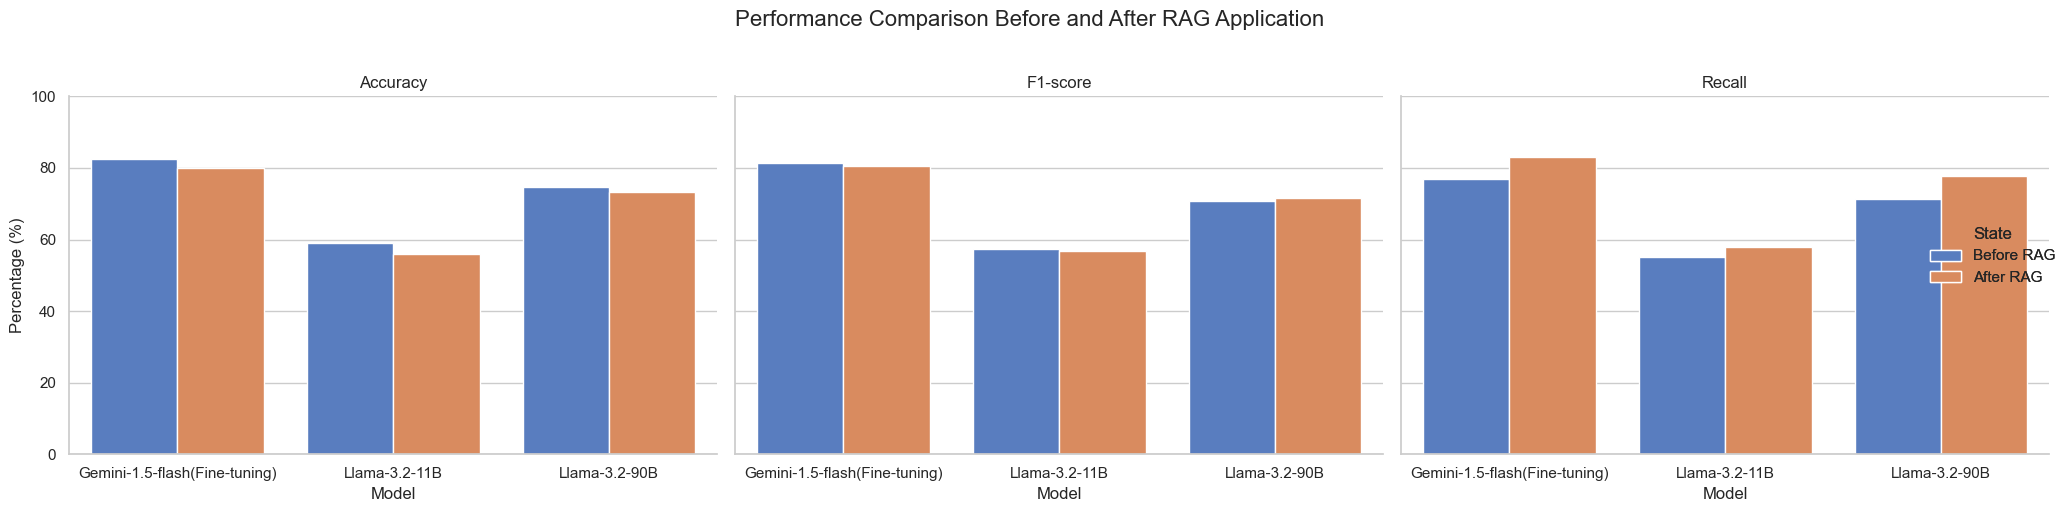

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Data for the models before and after RAG application
data_before = {
    "Model": [
        "Gemini-1.5-flash(Fine-tuning)",
        "Llama-3.2-11B",
        "Llama-3.2-90B",
    ],
    "Accuracy": [82.5, 59.0, 74.7],
    "F1-score": [81.4, 57.29, 70.9],
    "Recall": [77.0, 55.0, 71.4],
}

data_after = {
    "Model": [
        "Gemini-1.5-flash(Fine-tuning)",
        "Llama-3.2-11B",
        "Llama-3.2-90B",
    ],
    "Accuracy": [80.0, 56.0, 73.3],
    "F1-score": [80.6, 56.9, 71.5],
    "Recall": [83.0, 58.0, 77.8],
}

# Convert data to DataFrame
df_before = pd.DataFrame(data_before)
df_after = pd.DataFrame(data_after)

# Combine the before and after data for seaborn visualization
df_before["State"] = "Before RAG"
df_after["State"] = "After RAG"
df_combined = pd.concat([df_before, df_after]).reset_index()

# Melt the data for seaborn compatibility
df_melted = pd.melt(
    df_combined,
    id_vars=["Model", "State"],
    value_vars=["Accuracy", "F1-score", "Recall"],
    var_name="Metric",
    value_name="Value",
)

# Create a seaborn plot
sns.set(style="whitegrid")
g = sns.catplot(
    data=df_melted,
    x="Model",
    y="Value",
    hue="State",
    col="Metric",
    kind="bar",
    height=5,
    aspect=1.2,
    palette="muted",
)

# Customize the plot
g.set_axis_labels("Model", "Percentage (%)")
g.set_titles("{col_name}")
g.set(ylim=(0, 100))
g.fig.suptitle(
    "Performance Comparison Before and After RAG Application", y=1.02, fontsize=16
)
g.add_legend(title="State")

plt.tight_layout()
plt.show()

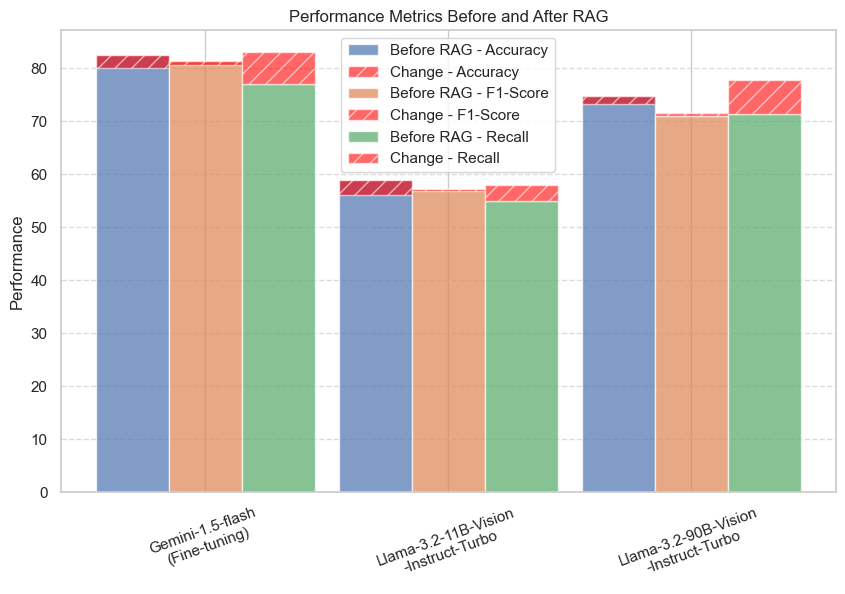

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 및 성능 지표 데이터
models = [
    "Gemini-1.5-flash\n(Fine-tuning)",
    "Llama-3.2-11B-Vision\n-Instruct-Turbo",
    "Llama-3.2-90B-Vision\n-Instruct-Turbo",
]
metrics = ["Accuracy", "F1-Score", "Recall"]

# RAG 적용 전 성능
before_rag = np.array([[82.5, 81.4, 77.0], [59.0, 57.29, 55.0], [74.7, 70.9, 71.4]])

# RAG 적용 후 성능
after_rag = np.array([[80.0, 80.6, 83.0], [56.0, 56.9, 58.0], [73.3, 71.5, 77.8]])

# 성능 변화량 계산
change_rag = after_rag - before_rag

# 시각화: 막대 그래프
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3
x = np.arange(len(models))

# 원래 성능과 변화량을 같은 그래프에서 시각화
for i in range(3):
    ax.bar(
        x + i * bar_width,
        before_rag[:, i],
        width=bar_width,
        label=f"Before RAG - {metrics[i]}",
        alpha=0.7,
    )
    ax.bar(
        x + i * bar_width,
        after_rag[:, i] - before_rag[:, i],
        width=bar_width,
        bottom=before_rag[:, i],
        label=f"Change - {metrics[i]}",
        hatch="//",
        color="red",
        alpha=0.6,
    )

# 레이블 설정
ax.set_xticks(x + bar_width)
ax.set_xticklabels(models)
ax.set_ylabel("Performance")
ax.set_title("Performance Metrics Before and After RAG")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

# 그래프 표시
plt.xticks(rotation=20)
plt.show()

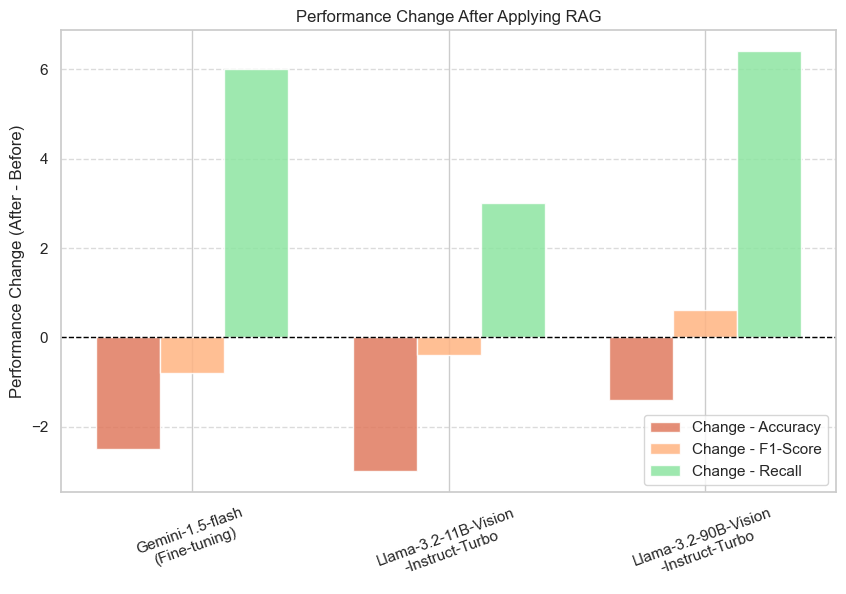

In [20]:
# 개선된 시각화: 파스텔톤 색상 적용

# 파스텔톤 색상 지정
pastel_colors = ["#E07A5F", "#FFB482", "#8DE5A1"]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25  # 막대 너비 유지
x = np.arange(len(models))

# 성능 변화량을 강조한 그래프 (파스텔톤 색상 적용)
for i in range(3):
    ax.bar(
        x + (i - 1) * bar_width,
        change_rag[:, i],
        width=bar_width,
        label=f"Change - {metrics[i]}",
        alpha=0.85,
        color=pastel_colors[i],
    )

# 기준선(변화 없음) 추가
ax.axhline(0, color="black", linewidth=1, linestyle="--")

# 레이블 설정
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel("Performance Change (After - Before)")
ax.set_title("Performance Change After Applying RAG")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

# 그래프 표시
plt.xticks(rotation=20)
plt.show()